# Домашнее задание 2. Классификация изображений.

## Вступление

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import os
import abc
import time
import typing
import random
import warnings

import PIL
import tqdm
import torch
import wandb
import numpy
import pandas
import torchscan
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


In [2]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [3]:
class MysteriousDataset(torchdata.Dataset):
    def __init__(
            self,
            train: bool,
            preload: bool = True,
            precalculate_transform: bool = True,
            transform: typing.Optional[transforms.Compose] = None
        ):
        # Create a way to easily read from disk
        self.name = "train" if train else "val"
        self.dataset_src = "./dataset/{}".format(self.name)
        self.dataset = torchvision.datasets.ImageFolder(self.dataset_src)

        self.classes = self.dataset.classes
        self.precalculated_transform = None
        self.transform = None

        # The dataset is not that big, so we might want to load it into RAM beforehand
        if preload or precalculate_transform:
            if precalculate_transform:
                # We might also want to precalculate the transform
                self.precalculated_transform = transform
                self.transform = transform
                transform = None
            # If precalculate_transform is True, self.transform is set, and __getitem__ will apply the transforms
            self.images, self.targets = self.load_all("Preload {}".format(self.name))
        # If precalculate_transform is True, this will be None
        self.transform = transform

    def load_all(self, progress_bar: bool = False):
        images = [ ]
        targets = [ ]
        for record in (tqdm.tqdm(self, desc = progress_bar.ljust(15)) if progress_bar else self):
            images.append(record[0])
            targets.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), targets
        except: return images, targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self, 'images') and hasattr(self, 'targets'):
            # If the data has been preloaded, use it
            image, target = self.images[idx], self.targets[idx]
        else:
            # Access the source
            image, target = self.dataset[idx]
        # Apply the transform if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
    def channel_stats(self):
        images, _ = self.load_all() # Get the dataset as two tensors
        # Calculate the metrics
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

In [4]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

no_preload = MysteriousDataset(True, transform = transform, preload = False, precalculate_transform = False)
no_precalc = MysteriousDataset(True, transform = transform, preload = True, precalculate_transform = False)
preload = MysteriousDataset(True, transform = transform, preload = True, precalculate_transform = True)
torch_dataset = torchvision.datasets.ImageFolder("./dataset/train", transform = transform)

Preload train  : 100%|██████████| 100000/100000 [00:27<00:00, 3694.67it/s]


In [5]:
# Check that it is actually faster to loop through the dataset when it is preloaded into RAM
def test_loading(*args):
    for dataset, desc in args:
        loader = torchdata.DataLoader(dataset, batch_size = 256)
        for item in tqdm.tqdm(loader, desc = desc.ljust(15)):
            pass

test_loading(
    (torch_dataset, 'ImageFolder'),
    (no_preload, 'no_preload'),
    (no_precalc, 'no_precalc'),
    (preload, 'preload')
)

preload        : 100%|██████████| 391/391 [00:00<00:00, 603.63it/s]


#### Посчитаем поканальные средние и стандартные отклонения для нормализации данных

In [6]:
mean, std = preload.channel_stats()
print(mean, std)

tensor([0.4802, 0.4481, 0.3975]) tensor([0.2764, 0.2689, 0.2816])


In [7]:
del torch_dataset
del no_preload
del no_precalc
del preload

#### Создадим датасеты

In [8]:
fix_random()

# Transforms
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

# Load datasets
train_set = MysteriousDataset(train = True, preload = True, precalculate_transform = True, transform = transform)
test_set = MysteriousDataset(train = False, preload = True, precalculate_transform = True, transform = transform)

# Check
print(len(train_set), len(test_set))

# Just very simple sanity checks
assert isinstance(train_set[0], tuple)
assert len(train_set[0]) == 2
assert isinstance(train_set[1][1], int)
assert isinstance(train_set[1][0], torch.Tensor)
assert train_set[1][0].shape == torch.Size([ 3, 64, 64 ])
print("Dataset tests passed")

for images, targets in torchdata.DataLoader(train_set, batch_size = 256):
    assert isinstance(images, torch.Tensor)
    assert isinstance(targets, torch.Tensor)
    assert images.shape == torch.Size([ 256, 3, 64, 64 ])
    assert targets.shape == torch.Size([ 256 ])
    print("DataLoader tests passed")
    break

Preload val    : 100%|██████████| 10000/10000 [00:31<00:00, 315.91it/s]


100000 10000
Dataset tests passed
DataLoader tests passed


### Посмотрим на картиночки

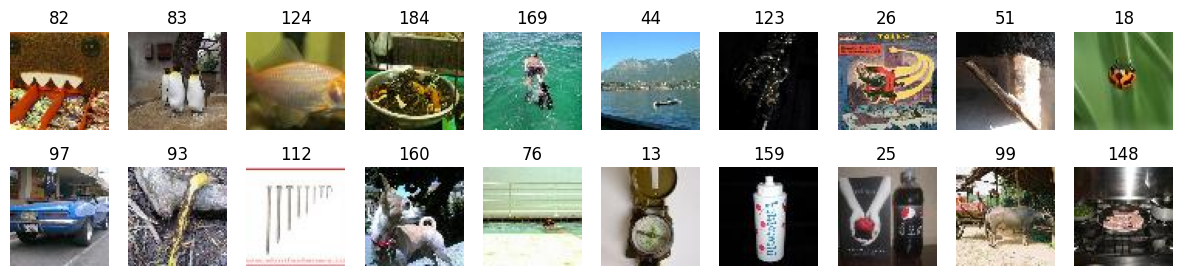

In [9]:
fix_random()

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

# Display some samples from each dataset
def display_examples(dataset: MysteriousDataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Классификатор

In [10]:
class BaseClassifier(abc.ABC):
    @abc.abstractmethod
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
    
    def calc_metrics(self, dataset: torchdata.Dataset) -> dict:
        num_classes = self.output_shape[0] if hasattr(self, 'output_shape') else len(dataset.classes)
        classes = torch.arange(num_classes)

        all_labels = torch.tensor([])
        all_predictions = torch.tensor([])
        all_scores = torch.empty((0, num_classes))
        loader = torchdata.DataLoader(dataset, batch_size = 512, shuffle = False)
        for images, labels in loader:
            predictions, scores = self.predict(images)
            all_labels = torch.cat([ all_labels, labels ])
            all_scores = torch.cat([ all_scores, scores.detach().cpu() ])
            all_predictions = torch.cat([ all_predictions, predictions.detach().cpu() ])

        return {
            'Accuracy':       sklearn.metrics.accuracy_score      (all_labels, all_predictions),
            'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 2, labels = classes),
            'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 3, labels = classes),
            'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 4, labels = classes),
            'TOP-5 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 5, labels = classes),
            'TOP-6 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 6, labels = classes),
            'TOP-7 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 7, labels = classes),
            'TOP-8 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 8, labels = classes),
            'TOP-9 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 9, labels = classes),
            # 'AUC-ROC':        sklearn.metrics.roc_auc_score       (all_labels, all_scores, multi_class = 'ovo'),
            'Precision':      sklearn.metrics.precision_score     (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'Recall':         sklearn.metrics.recall_score        (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'F1-score':       sklearn.metrics.f1_score            (all_labels, all_predictions, average = 'macro', zero_division = 0)
        }

In [11]:
class Classifier(BaseClassifier):
    results = [ ]

    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            learning_rate: int = 1e-3,
            device: torch.device = device,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        ):
        self.name = name
        self.history = [ ]
        self.device = device
        self.input_shape = None
        self.output_shape = None
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.model = model.to(self.device)
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(), lr = learning_rate)


    def train(self, images: torch.Tensor, labels: torch.Tensor) -> float:
        self.model.train() # Enter train mode
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(images.to(self.device)) # Get predictions
        loss = torch.nn.functional.cross_entropy(output, labels.to(self.device)) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        sum_loss = 0
        for images, labels in loader:
            sum_loss += self.train(images, labels) # Train one batch
        if self.scheduler is not None:
            self.scheduler.step()
        return sum_loss / len(loader) # Return average loss to avoid random-dependent graph
       
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset, n_epochs: int = 25, silent: bool = False):
        if self.input_shape is None or self.output_shape is None:
            self.predict(train_set[0][0].unsqueeze(0)) # Initialize lazy layers and in/out shapes
        loader = torchdata.DataLoader(train_set, batch_size = self.batch_size, shuffle = True)

        wandb_settings = { "silent": True, "disable_git": True } if silent else None
        wandb.init(project = "DL-HW-2", name = self.name, anonymous = "allow", settings = wandb_settings)
        wandb.watch(self.model, log = "all")

        for epoch in tqdm.trange(n_epochs, desc = "Fit {}".format(self.name).ljust(25)):
            # Train
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start

            # Validate
            val_start = time.perf_counter()
            metrics = self.calc_metrics(val_set)
            val_time = time.perf_counter() - val_start
            
            # Upload metrics
            metrics['Validation time'] = val_time
            metrics['Train time'] = train_time
            metrics['Loss'] = loss
            wandb.log(metrics)
            metrics['Epoch'] = epoch + 1
            self.history.append(metrics)

        # Finish the run
        wandb.finish(quiet = True)

        # Store best metrics
        self.best_metrics = max(self.history, key = lambda item: item['Accuracy'])
        Classifier.results.append({ 'Name': self.name, **self.best_metrics })
        return self
    

    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        if self.input_shape is None:
            self.input_shape = images[0].shape # Lazily initialize input shape

        self.model.eval() # Enter evaluation mode
        with torch.no_grad():
            outputs = self.model(images.to(self.device)) # Get outputs
            scores = torch.softmax(outputs, dim = 1) # Make probabilities
            predictions = torch.argmax(scores, dim = 1) # Calculate predictions

        if self.output_shape is None:
            self.output_shape = scores[0].shape # Lazily initialize output shape
        return predictions, scores
    

    def summary(self):
        display(pandas.DataFrame(Classifier.results)) # Print run history
        warnings.filterwarnings("ignore") # Ignore warnings that might be printed by torchscan.summary
        torchscan.summary(self.model.eval(), self.input_shape, receptive_field = True) # Print summary about this model

### Эксперименты

Будем использовать свертки размера 3x3 с отступом 1. Количество фильтров будем увеличивать в два раза с каждой сверткой, начиная с 16. После каждого слоя будем применять нормализацию и макс-пулинг размера 2x2. \
Для классификации создадим два полносвязных слоя с 1024 и 200 нейронами соответственно (выходы второго - ответы модели для каждого класса). Между слоями добавим нормализацию, а во избежание переобучения перед обоими слоями будем использовать Dropout с вероятностью 0.5. \
В качестве нелинейности выберем GELU. В прошлом ДЗ эта функция показала себя немного лучше других, но сильного влияния на качество это не должно оказывать.

Попробуем модели с различным количеством сверточных слоев.

In [12]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200)
)
Classifier('3 convolutions', model).fit(train_set, test_set).summary()

d:\Programs\Programming\Python\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fit 3 convolutions       : 100%|██████████| 25/25 [05:14<00:00, 12.59s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,3 convolutions,0.3504,0.4614,0.5264,0.5705,0.6102,0.6405,0.6636,0.6839,0.7002,0.343616,0.3504,0.332519,0.835988,11.923526,1.992931,15


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               22             
├─0                          Conv2d                (-1, 16, 64, 64)          448             22             
├─1                          BatchNorm2d           (-1, 16, 64, 64)          65              20             
├─2                          GELU                  (-1, 16, 64, 64)          0               20             
├─3                          MaxPool2d             (-1, 16, 32, 32)          0               20             
├─4                          Conv2d                (-1, 32, 32, 32)          4,640           10             
├─5                          BatchNorm2d           (-1, 32, 32, 32)          129             8              
├─6                

In [13]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(128), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200)
)
Classifier('4 convolutions', model).fit(train_set, test_set).summary()

Fit 4 convolutions       : 100%|██████████| 25/25 [05:11<00:00, 12.47s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,3 convolutions,0.3504,0.4614,0.5264,0.5705,0.6102,0.6405,0.6636,0.6839,0.7002,0.343616,0.3504,0.332519,0.835988,11.923526,1.992931,15
1,4 convolutions,0.3993,0.5131,0.5848,0.6283,0.6646,0.6916,0.7153,0.7350,0.7527,0.399605,0.3993,0.379131,0.832598,11.584189,1.872928,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               46             
├─0                          Conv2d                (-1, 16, 64, 64)          448             46             
├─1                          BatchNorm2d           (-1, 16, 64, 64)          65              44             
├─2                          GELU                  (-1, 16, 64, 64)          0               44             
├─3                          MaxPool2d             (-1, 16, 32, 32)          0               44             
├─4                          Conv2d                (-1, 32, 32, 32)          4,640           22             
├─5                          BatchNorm2d           (-1, 32, 32, 32)          129             20             
├─6                

In [14]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(128), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(256), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200)
)
Classifier('5 convolutions', model).fit(train_set, test_set).summary()

Fit 5 convolutions       : 100%|██████████| 25/25 [05:37<00:00, 13.50s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,3 convolutions,0.3504,0.4614,0.5264,0.5705,0.6102,0.6405,0.6636,0.6839,0.7002,0.343616,0.3504,0.332519,0.835988,11.923526,1.992931,15
1,4 convolutions,0.3993,0.5131,0.5848,0.6283,0.6646,0.6916,0.7153,0.7350,0.7527,0.399605,0.3993,0.379131,0.832598,11.584189,1.872928,23
2,5 convolutions,0.3966,0.5107,0.5814,0.6238,0.6600,0.6870,0.7124,0.7315,0.7468,0.402644,0.3966,0.381198,0.866410,12.429149,1.756624,22


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               94             
├─0                          Conv2d                (-1, 16, 64, 64)          448             94             
├─1                          BatchNorm2d           (-1, 16, 64, 64)          65              92             
├─2                          GELU                  (-1, 16, 64, 64)          0               92             
├─3                          MaxPool2d             (-1, 16, 32, 32)          0               92             
├─4                          Conv2d                (-1, 32, 32, 32)          4,640           46             
├─5                          BatchNorm2d           (-1, 32, 32, 32)          129             44             
├─6                

![Alternative Text][1699452889745]

[1699452889745]: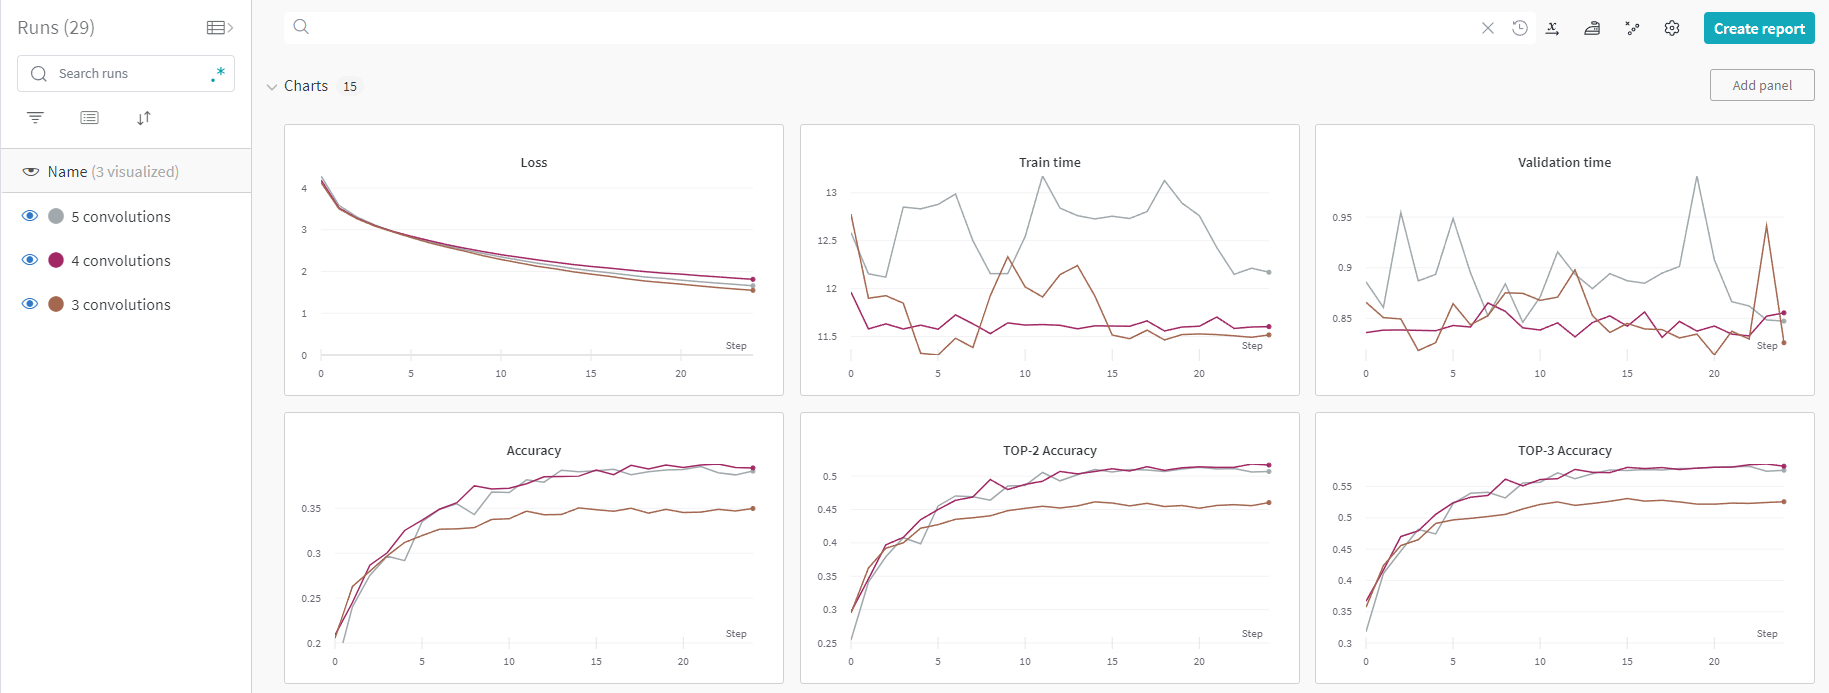

Добавление четвертого слоя заметно улучшило качество модели, но пятый слой лишь немного его понизил. \
Заметим, что поле восприятия пятого слоя - 94 - явно больше размера обрабатываемых картинок (64x64), а третьего слоя - 22 - заметно меньше. Четвёртый слой же "видит" 46 пикселей, что наиболее близко к реальному размеру картинок. Следовательно, можно предоложить, что наилучшего качества достигнет модель с полем восприятия, равным размеру картинки.

Попробуем убрать одно применения пулинга после четвертого слоя. Это понизит поле восприятия до 62.

In [15]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(128), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(256), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200)
)
Classifier('Receptive Field 62', model).fit(train_set, test_set).summary()

Fit Receptive Field 62   : 100%|██████████| 25/25 [06:26<00:00, 15.47s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,3 convolutions,0.3504,0.4614,0.5264,0.5705,0.6102,0.6405,0.6636,0.6839,0.7002,0.343616,0.3504,0.332519,0.835988,11.923526,1.992931,15
1,4 convolutions,0.3993,0.5131,0.5848,0.6283,0.6646,0.6916,0.7153,0.7350,0.7527,0.399605,0.3993,0.379131,0.832598,11.584189,1.872928,23
2,5 convolutions,0.3966,0.5107,0.5814,0.6238,0.6600,0.6870,0.7124,0.7315,0.7468,0.402644,0.3966,0.381198,0.866410,12.429149,1.756624,22
3,Receptive Field 62,0.4229,0.5371,0.6024,0.6478,0.6815,0.7082,0.7313,0.7492,0.7626,0.424902,0.4229,0.411161,0.923044,14.220409,1.034419,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               62             
├─0                          Conv2d                (-1, 16, 64, 64)          448             62             
├─1                          BatchNorm2d           (-1, 16, 64, 64)          65              60             
├─2                          GELU                  (-1, 16, 64, 64)          0               60             
├─3                          MaxPool2d             (-1, 16, 32, 32)          0               60             
├─4                          Conv2d                (-1, 32, 32, 32)          4,640           30             
├─5                          BatchNorm2d           (-1, 32, 32, 32)          129             28             
├─6                

![Alternative Text][1699452948826]

[1699452948826]: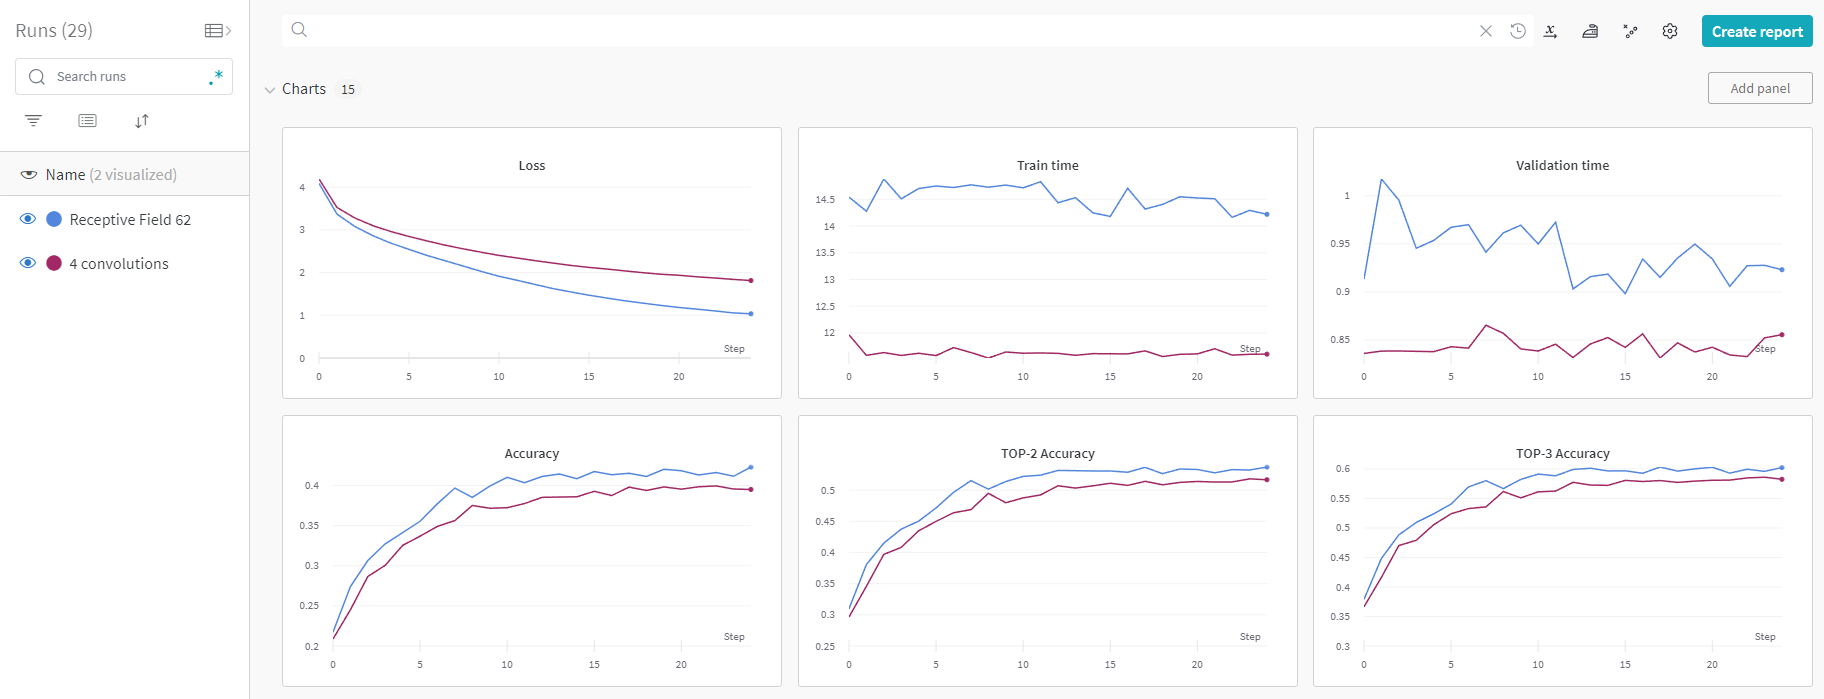

Действительно, эта модель показывает гораздо более хорошее качество. Попробуем увеличить поле восприятия до 64 добавлением ещё одного свёрточного слоя в начало.

In [16]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(128), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(256), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(512), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200)
)
Classifier('Receptive Field 64', model).fit(train_set, test_set).summary()

Fit Receptive Field 64   : 100%|██████████| 25/25 [17:01<00:00, 40.84s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,3 convolutions,0.3504,0.4614,0.5264,0.5705,0.6102,0.6405,0.6636,0.6839,0.7002,0.343616,0.3504,0.332519,0.835988,11.923526,1.992931,15
1,4 convolutions,0.3993,0.5131,0.5848,0.6283,0.6646,0.6916,0.7153,0.7350,0.7527,0.399605,0.3993,0.379131,0.832598,11.584189,1.872928,23
2,5 convolutions,0.3966,0.5107,0.5814,0.6238,0.6600,0.6870,0.7124,0.7315,0.7468,0.402644,0.3966,0.381198,0.866410,12.429149,1.756624,22
3,Receptive Field 62,0.4229,0.5371,0.6024,0.6478,0.6815,0.7082,0.7313,0.7492,0.7626,0.424902,0.4229,0.411161,0.923044,14.220409,1.034419,25
4,Receptive Field 64,0.4542,0.5742,0.6398,0.6818,0.7130,0.7413,0.7607,0.7801,0.7958,0.457203,0.4542,0.445938,1.716692,38.380190,0.674795,16


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               64             
├─0                          Conv2d                (-1, 16, 64, 64)          448             64             
├─1                          BatchNorm2d           (-1, 16, 64, 64)          65              62             
├─2                          GELU                  (-1, 16, 64, 64)          0               62             
├─3                          Conv2d                (-1, 32, 64, 64)          4,640           62             
├─4                          BatchNorm2d           (-1, 32, 64, 64)          129             60             
├─5                          GELU                  (-1, 32, 64, 64)          0               60             
├─6                

![Alternative Text][1699452992148]

[1699452992148]: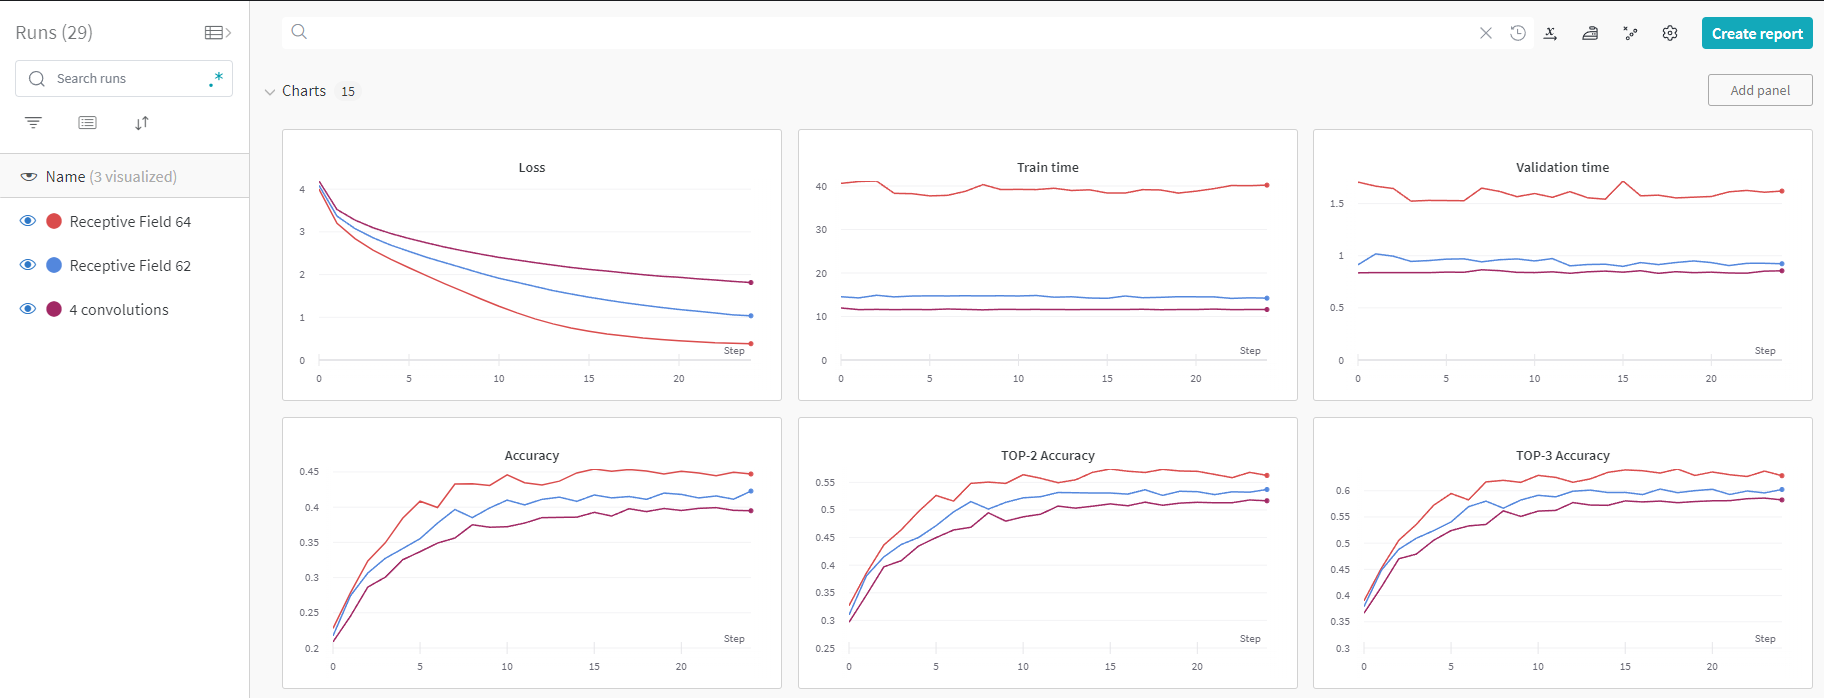

Однозначно, стало лучше. Попробуем добавить scheduler, чтобы стабилизировать процесс обучения

In [17]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(128), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(256), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(512), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200)
).to(device)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
Classifier('Scheduler', model, optimizer = optimizer, scheduler = scheduler).fit(train_set, test_set).summary()

Fit Scheduler            : 100%|██████████| 25/25 [16:56<00:00, 40.65s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,3 convolutions,0.3504,0.4614,0.5264,0.5705,0.6102,0.6405,0.6636,0.6839,0.7002,0.343616,0.3504,0.332519,0.835988,11.923526,1.992931,15
1,4 convolutions,0.3993,0.5131,0.5848,0.6283,0.6646,0.6916,0.7153,0.7350,0.7527,0.399605,0.3993,0.379131,0.832598,11.584189,1.872928,23
2,5 convolutions,0.3966,0.5107,0.5814,0.6238,0.6600,0.6870,0.7124,0.7315,0.7468,0.402644,0.3966,0.381198,0.866410,12.429149,1.756624,22
3,Receptive Field 62,0.4229,0.5371,0.6024,0.6478,0.6815,0.7082,0.7313,0.7492,0.7626,0.424902,0.4229,0.411161,0.923044,14.220409,1.034419,25
4,Receptive Field 64,0.4542,0.5742,0.6398,0.6818,0.7130,0.7413,0.7607,0.7801,0.7958,0.457203,0.4542,0.445938,1.716692,38.380190,0.674795,16
5,Scheduler,0.4692,0.5868,0.6529,0.6975,0.7292,0.7548,0.7774,0.7925,0.8056,0.461364,0.4692,0.460070,1.602579,39.294616,0.431816,22


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               64             
├─0                          Conv2d                (-1, 16, 64, 64)          448             64             
├─1                          BatchNorm2d           (-1, 16, 64, 64)          65              62             
├─2                          GELU                  (-1, 16, 64, 64)          0               62             
├─3                          Conv2d                (-1, 32, 64, 64)          4,640           62             
├─4                          BatchNorm2d           (-1, 32, 64, 64)          129             60             
├─5                          GELU                  (-1, 32, 64, 64)          0               60             
├─6                

![Alternative Text][1699453022284]

[1699453022284]: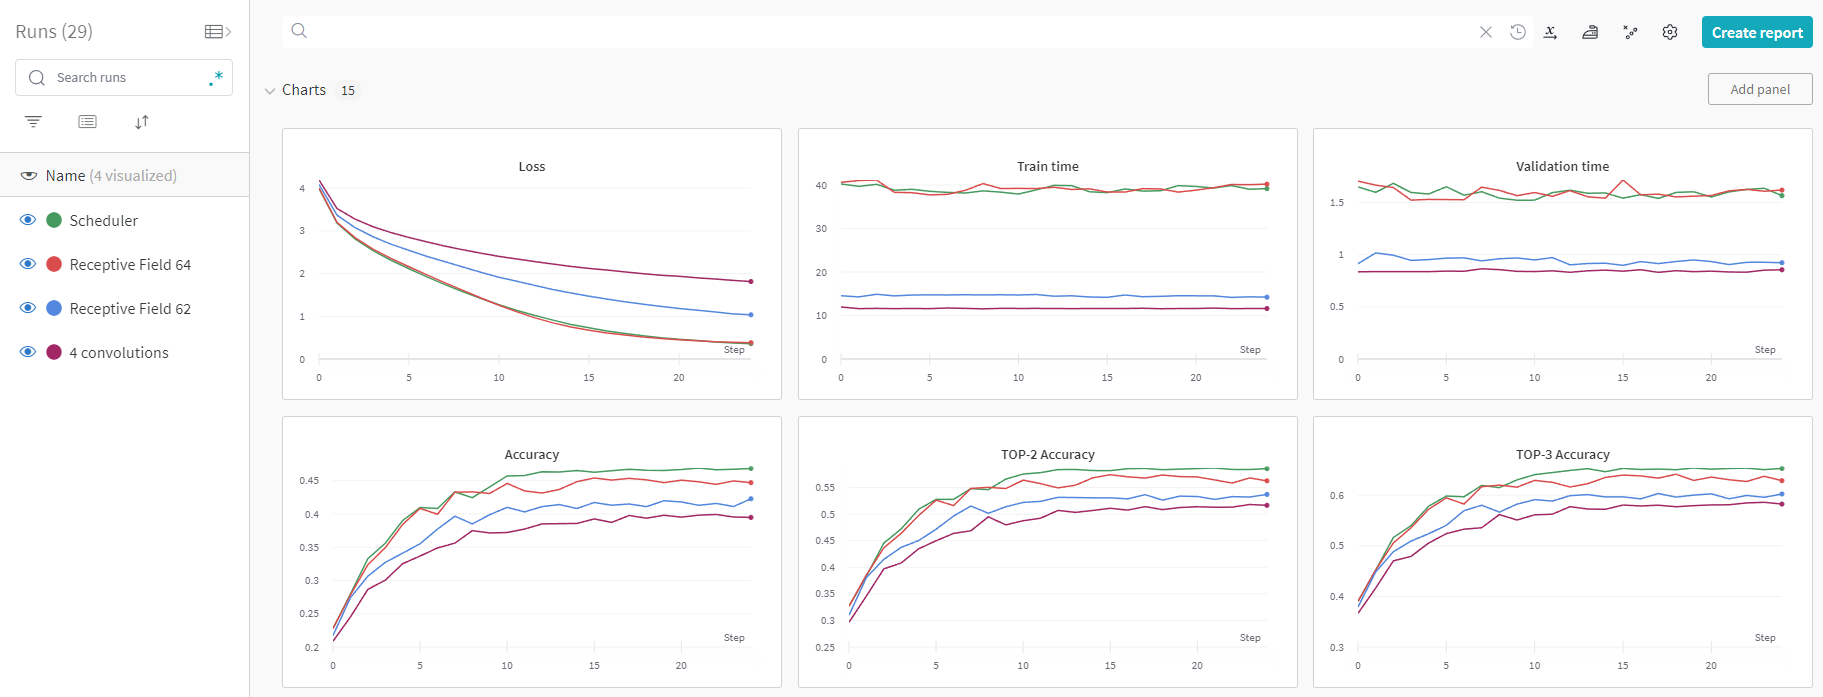

Лучшее качество достигается на 22 эпохе. Возьмём эту модель в качестве итоговой. Обучим заново для валидации результата

### Итоговая модель

In [18]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(128), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(256), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(512), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200)
).to(device)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
final_model = Classifier('Task 1 final', model, optimizer = optimizer, scheduler = scheduler).fit(train_set, test_set, 22)

Fit Task 1 final         : 100%|██████████| 22/22 [14:49<00:00, 40.45s/it]


In [19]:
accuracy = final_model.calc_metrics(test_set)['Accuracy']
print(f"Accuracy: {accuracy * 100}%")
print(f"Оценка за это задание составит {numpy.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

Accuracy: 46.92%
Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Датасет

Кажется, нужное качество можно достичь без аугментаций, поэтому будем просто получать векторы признаков, соответствующие картинкам, с помощью предобученных моделей, а затем обучать простейшую полносвязную сеть, состоящую из двух слоёв с 1024 и 200 нейронами соответственно.

In [20]:
class FeaturesDataset(torchdata.StackDataset):
    def __init__(
            self,
            extractor_name: str,
            dataset: torchdata.Dataset,
            batch_size: int = 256,
            extractor_device: torch.device = device
        ):
        self.name = 'Features for {}'.format(dataset.name if hasattr(dataset, 'name') else 'undefined')

        # If it is already a dataset of features, return
        if isinstance(dataset, FeaturesDataset):
            return super().__init__(dataset)

        # https://github.com/pytorch/vision/issues/7744
        def get_state_dict(self, *args, **kwargs):
            kwargs.pop("check_hash")
            return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
        torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

        # Load a pretrained model
        self.weights = torchvision.models.get_model_weights(extractor_name).DEFAULT
        self.extractor = torchvision.models.get_model(extractor_name, weights = self.weights)
        self.transform = self.weights.transforms()
        self.extractor_device = extractor_device

        # Remove last layer
        if hasattr(self.extractor, 'fc'): self.extractor.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.extractor, 'classifier'): self.extractor.classifier = torch.nn.Identity() # All others
        
        save_transform = dataset.transform if hasattr(dataset, 'transform') else None
        dataset.transform = None
        assert isinstance(dataset[0][0], PIL.Image.Image) # Without transforms it should return raw images
        dataset.transform = self.transform # Use transforms for pretrained model

        targets = [ ]
        features = [ ]
        self.extractor.to(self.extractor_device).eval() # Enter evaluation mode
        loader = torchdata.DataLoader(dataset, batch_size = batch_size) # Create a dataloader
        for images_batch, targets_batch in tqdm.tqdm(loader, desc = self.name.ljust(25)):
            with torch.no_grad():
                # Calculate features
                features_batch = self.extractor(images_batch.to(self.extractor_device))
                features.append(features_batch.detach().cpu().flatten(start_dim = 1))
                targets.append(targets_batch)

        # Free up the GPU
        self.extractor = self.extractor.to('cpu')
        if self.extractor_device.type == 'cuda': torch.cuda.empty_cache()
        elif self.extractor_device.type == 'mps': torch.mps.empty_cache()

        dataset.transform = save_transform # Restore transforms of the base dataset
        super().__init__(torch.cat(features), torch.cat(targets)) # Initialize StackDataset

In [21]:
# Make datasets without transforms to calculate image features
train_set = MysteriousDataset(train = True, preload = True, precalculate_transform = True, transform = None)
test_set = MysteriousDataset(train = False, preload = True, precalculate_transform = True, transform = None)

Preload val    : 100%|██████████| 10000/10000 [00:01<00:00, 6845.32it/s]


### Попробуем различные модели

Возьмём по одному виду каждой модели, реалиованной в `torchivision.models`. По возможности будем использовать версию модели, которая достигает наибольшего качества на датасете ImageNet. Тем не менее если выделение признаков при таком выборе занимает слишком много времени (например, в случае `efficientnet_b7` - более 2-х часов), будем пробовать более маленькие версии. Я решил, что выделение признаков не должно занимать более 25 минут. Для каждой модели также зафиксируем размер пакета, используемый при выделении признаков. Я выбирал наибольшее значение, при котором вычисления можно производить на видеокарте (NVIDIA GeForce GTX 1660 SUPER, 6GB) без переполнения памяти

In [22]:
models = [
    ("alexnet", 1024),
    ("convnext_base", 128),
    ("densenet201", 256),
    ("efficientnet_b4", 64),
    ("efficientnet_v2_s", 128),
    ("googlenet", 512),
    ("inception_v3", 256),
    ("mnasnet1_3", 256),
    ("mobilenet_v2", 256),
    ("mobilenet_v3_large", 512),
    ("regnet_x_8gf", 128),
    ("resnet152", 256),
    ("resnext101_64x4d", 128),
    ("shufflenet_v2_x2_0", 512),
    ("vgg19_bn", 64),
    ("wide_resnet101_2", 128)
]
Classifier.results = [ ]
for index, (extractor_name, batch_size) in enumerate(models):
    print("\033[95m{}\033[0m (\033[92m{}\033[0m/\033[94m{}\033[0m):".format(extractor_name.upper(), index + 1, len(models)))

    fix_random()
    train_features = FeaturesDataset(extractor_name, train_set, batch_size = batch_size)
    test_features = FeaturesDataset(extractor_name, test_set, batch_size = batch_size)
    model = torch.nn.Sequential(torch.nn.LazyLinear(1024), torch.nn.GELU(), torch.nn.Linear(1024, 200))
    Classifier(extractor_name, model, learning_rate = 3e-5).fit(train_features, test_features, silent = True)

ALEXNET (1/16):


Fit alexnet              : 100%|██████████| 25/25 [02:21<00:00,  5.65s/it]


CONVNEXT_BASE (2/16):


Fit convnext_base        : 100%|██████████| 25/25 [00:42<00:00,  1.71s/it]


DENSENET201 (3/16):


Fit densenet201          : 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


EFFICIENTNET_B4 (4/16):


Fit efficientnet_b4      : 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


EFFICIENTNET_V2_S (5/16):


Fit efficientnet_v2_s    : 100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


GOOGLENET (6/16):


Fit googlenet            : 100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


INCEPTION_V3 (7/16):


Fit inception_v3         : 100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


MNASNET1_3 (8/16):


Fit mnasnet1_3           : 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


MOBILENET_V2 (9/16):


Fit mobilenet_v2         : 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


MOBILENET_V3_LARGE (10/16):


Fit mobilenet_v3_large   : 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


REGNET_X_8GF (11/16):


Fit regnet_x_8gf         : 100%|██████████| 25/25 [00:53<00:00,  2.16s/it]


RESNET152 (12/16):


Fit resnet152            : 100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


RESNEXT101_64X4D (13/16):


Fit resnext101_64x4d     : 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


SHUFFLENET_V2_X2_0 (14/16):


Fit shufflenet_v2_x2_0   : 100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


VGG19_BN (15/16):


Fit vgg19_bn             : 100%|██████████| 25/25 [05:22<00:00, 12.92s/it]


WIDE_RESNET101_2 (16/16):


Fit wide_resnet101_2     : 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


In [23]:
display(pandas.DataFrame(Classifier.results)) # Print run history

,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,alexnet,0.4965,0.6204,0.6906,0.7322,0.7594,0.7850,0.8023,0.8183,0.8328,0.505036,0.4965,0.491838,0.657736,4.860630,1.156493,9
1,convnext_base,0.8471,0.9112,0.9346,0.9490,0.9560,0.9623,0.9664,0.9696,0.9728,0.851846,0.8471,0.847448,0.629716,1.184911,0.503213,25
2,densenet201,0.7442,0.8370,0.8741,0.8981,0.9139,0.9252,0.9337,0.9407,0.9464,0.749994,0.7442,0.743785,0.538169,1.498976,0.812074,25
3,efficientnet_b4,0.7915,0.8771,0.9053,0.9224,0.9339,0.9426,0.9501,0.9552,0.9594,0.795795,0.7915,0.791410,0.516612,1.398490,0.731754,25
4,efficientnet_v2_s,0.7882,0.8687,0.9017,0.9206,0.9308,0.9388,0.9451,0.9512,0.9564,0.792742,0.7882,0.788211,0.619853,1.367328,0.661766,25
5,googlenet,0.6184,0.7351,0.7902,0.8235,0.8475,0.8632,0.8781,0.8896,0.8975,0.622716,0.6184,0.616324,0.516674,1.263762,1.412124,25
6,inception_v3,0.7016,0.8018,0.8466,0.8706,0.8870,0.9001,0.9098,0.9168,0.9230,0.707637,0.7016,0.701502,0.561538,1.566670,1.000412,25
7,mnasnet1_3,0.6930,0.7960,0.8428,0.8708,0.8866,0.8989,0.9108,0.9191,0.9258,0.696463,0.6930,0.692007,0.541540,1.325013,1.052547,25
8,mobilenet_v2,0.6328,0.7478,0.8003,0.8324,0.8537,0.8700,0.8844,0.8928,0.9025,0.635984,0.6328,0.630583,0.534373,1.317302,1.315003,25
9,mobilenet_v3_large,0.6780,0.7854,0.8353,0.8641,0.8849,0.8983,0.9084,0.9166,0.9243,0.683715,0.6780,0.677146,0.636612,1.209218,1.117170,24


![Alternative Text][1699453169969]

[1699453169969]: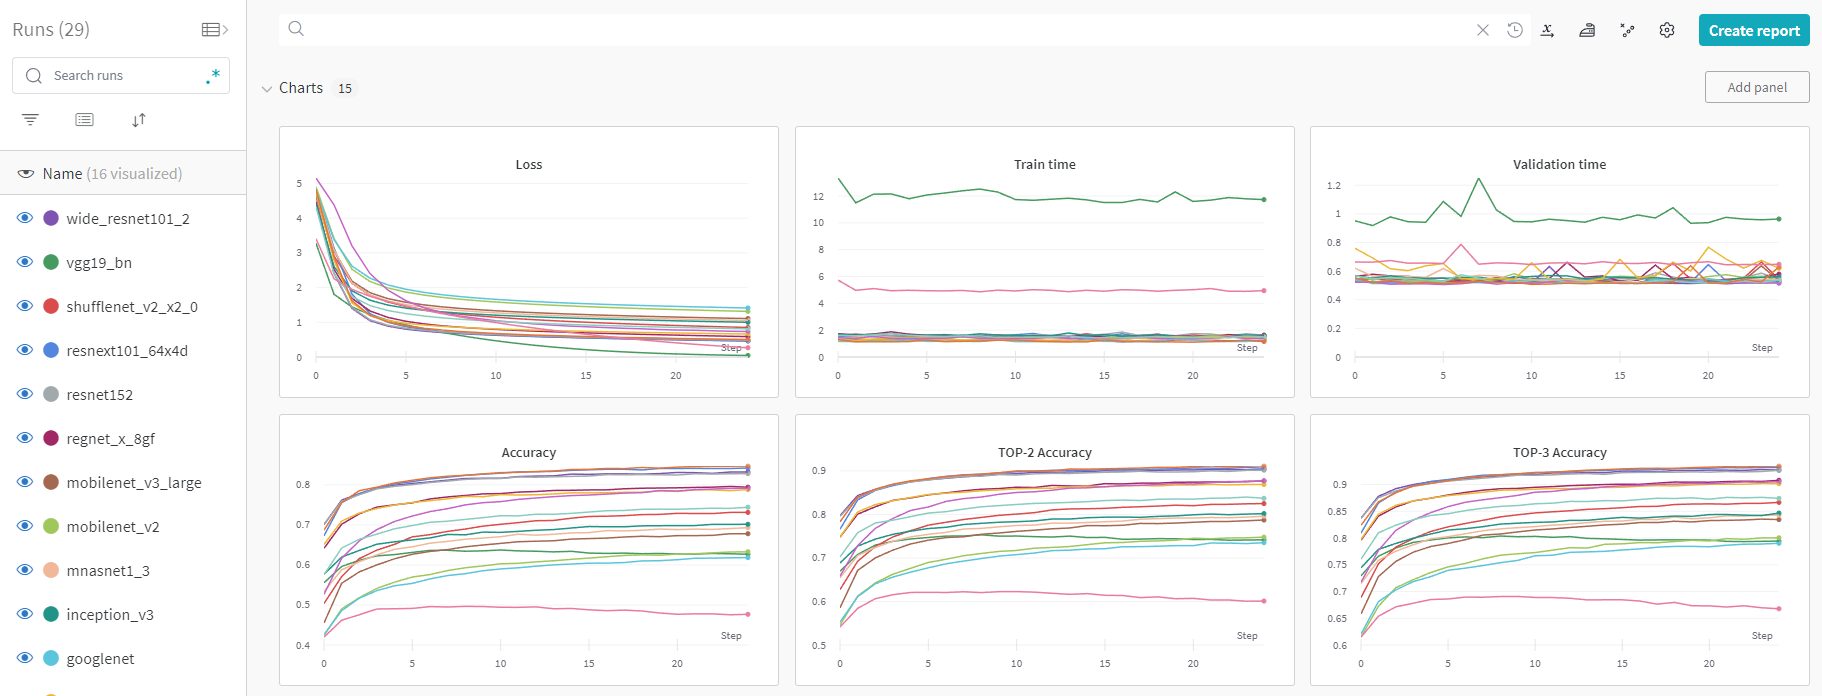

![Alternative Text][1699453241114]

[1699453241114]: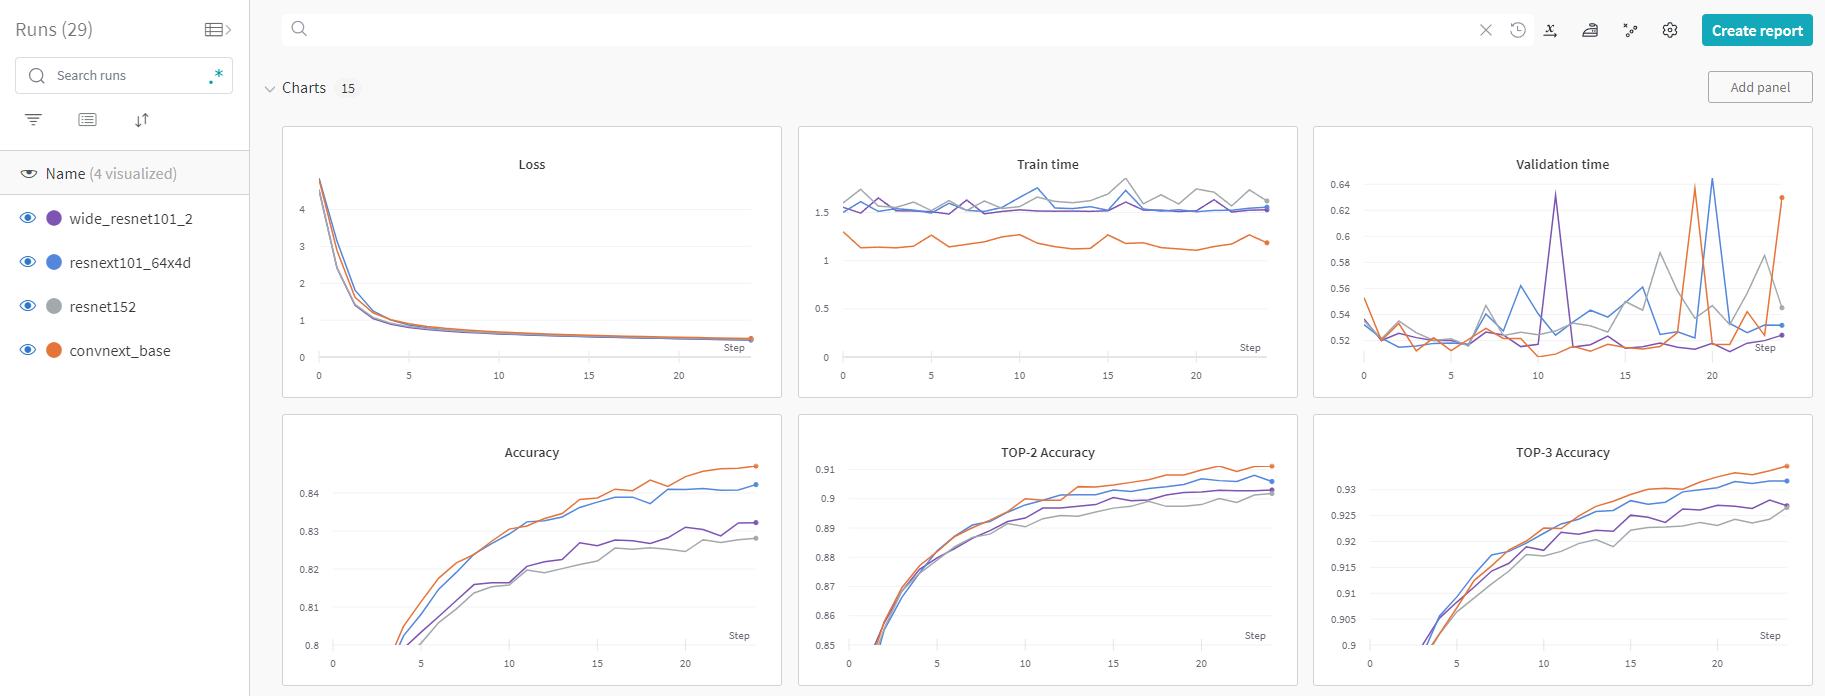

Видно, что среди рассмотренных моделей `convnext_base` показывает лучшее качество и достигает требуемых 84%. Попробуем ещё улучшить параметры модели, чтобы она достигала требуемого качества более "уверенно"

### Эксперименты

#### Датасеты признаков

In [24]:
fix_random()
train_features = FeaturesDataset("convnext_base", train_set, batch_size = 128)
test_features = FeaturesDataset("convnext_base", test_set, batch_size = 128)
Classifier.results = [ ]

Features for val         : 100%|██████████| 79/79 [02:20<00:00,  1.77s/it]


#### Количество полносвязных слоев

Попробуем разное количество полносвязных слоев, используемых для классификации

In [25]:
fix_random()
model = torch.nn.Sequential(torch.nn.LazyLinear(1024), torch.nn.GELU(), torch.nn.Linear(1024, 200))
Classifier('1024 + 200', model, learning_rate = 3e-5).fit(train_features, test_features, 100).summary()

Fit 1024 + 200           : 100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,1024 + 200,0.8572,0.9194,0.9407,0.9534,0.9601,0.9651,0.968,0.9712,0.9731,0.860992,0.8572,0.857409,0.614153,1.713959,0.341416,65


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               1              
├─0                          Linear                (-1, 1024)                1,049,600       1              
├─1                          GELU                  (-1, 1024)                0               1              
├─2                          Linear                (-1, 200)                 205,000         1              
Trainable params: 1,254,600
Non-trainable params: 0
Total params: 1,254,600
------------------------------------------------------------------------------------------------------------
Model size (params + buffers): 4.79 Mb
Framework & CUDA overhead: -191.26 Mb
Total RAM usage: -186.48 Mb
--------------------------------------------------------

In [26]:
fix_random()
model = torch.nn.LazyLinear(200)
Classifier('200', model, learning_rate = 3e-5).fit(train_features, test_features, 100).summary()

Fit 200                  : 100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,1024 + 200,0.8572,0.9194,0.9407,0.9534,0.9601,0.9651,0.9680,0.9712,0.9731,0.860992,0.8572,0.857409,0.614153,1.713959,0.341416,65
1,200,0.8533,0.9167,0.9394,0.9530,0.9609,0.9655,0.9698,0.9723,0.9752,0.857142,0.8533,0.853485,0.553387,1.170635,0.452905,100


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
linear                       Linear                (-1, 200)                 205,000         1              
Trainable params: 205,000
Non-trainable params: 0
Total params: 205,000
------------------------------------------------------------------------------------------------------------
Model size (params + buffers): 0.78 Mb
Framework & CUDA overhead: -175.25 Mb
Total RAM usage: -174.47 Mb
------------------------------------------------------------------------------------------------------------
Floating Point Operations on forward: 409.60 kFLOPs
Multiply-Accumulations on forward: 204.80 kMACs
Direct memory accesses on forward: 206.22 kDMAs
____________________________________________________________________________________________________________



In [27]:
fix_random()
model = torch.nn.Sequential(torch.nn.LazyLinear(1024), torch.nn.GELU(), torch.nn.Linear(1024, 512), torch.nn.GELU(), torch.nn.Linear(512, 200))
Classifier('1024 + 512 + 200', model, learning_rate = 3e-5).fit(train_features, test_features, 100).summary()

Fit 1024 + 512 + 200     : 100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,1024 + 200,0.8572,0.9194,0.9407,0.9534,0.9601,0.9651,0.9680,0.9712,0.9731,0.860992,0.8572,0.857409,0.614153,1.713959,0.341416,65
1,200,0.8533,0.9167,0.9394,0.9530,0.9609,0.9655,0.9698,0.9723,0.9752,0.857142,0.8533,0.853485,0.553387,1.170635,0.452905,100
2,1024 + 512 + 200,0.8509,0.9123,0.9356,0.9479,0.9565,0.9605,0.9646,0.9681,0.9699,0.854629,0.8509,0.851123,0.540771,1.381037,0.325489,70


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               1              
├─0                          Linear                (-1, 1024)                1,049,600       1              
├─1                          GELU                  (-1, 1024)                0               1              
├─2                          Linear                (-1, 512)                 524,800         1              
├─3                          GELU                  (-1, 512)                 0               1              
├─4                          Linear                (-1, 200)                 102,600         1              
Trainable params: 1,677,000
Non-trainable params: 0
Total params: 1,677,000
----------------------------------------------------

![Alternative Text][1699453833529]

[1699453833529]: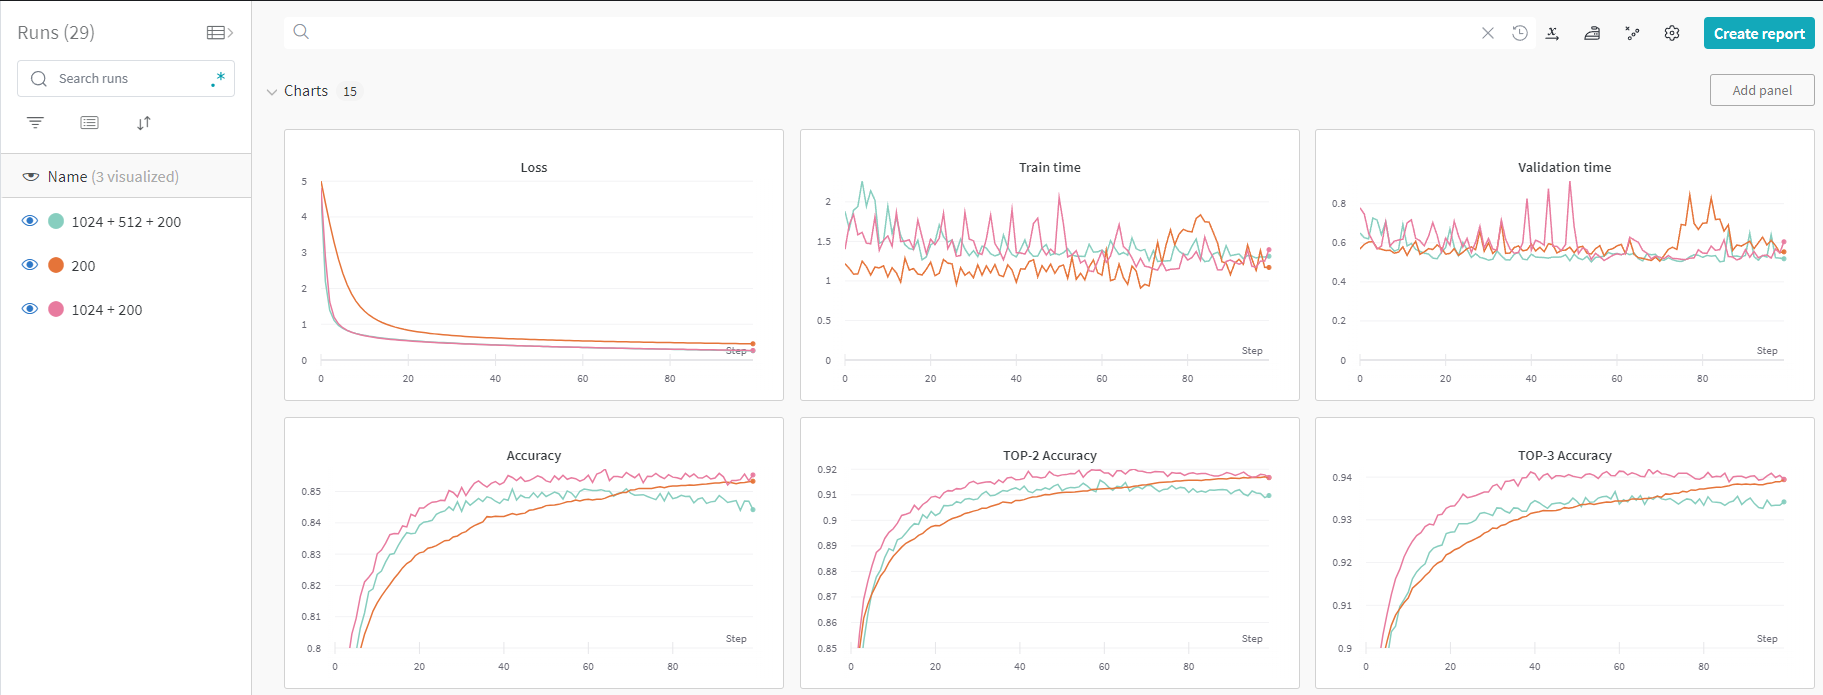

Наибольшего качества достигает модель с двумя полносвязными слоями, содержащими 1024 и 200 нейронов соответственно

#### Нормализация

Попробуем добавить нормализацию между слоями. Говорят, это должно улучшать модель

In [28]:
fix_random()
model = torch.nn.Sequential(torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(), torch.nn.Linear(1024, 200))
Classifier('BatchNorm', model, learning_rate = 3e-5).fit(train_features, test_features, 100).summary()

Fit BatchNorm            : 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,1024 + 200,0.8572,0.9194,0.9407,0.9534,0.9601,0.9651,0.9680,0.9712,0.9731,0.860992,0.8572,0.857409,0.614153,1.713959,0.341416,65
1,200,0.8533,0.9167,0.9394,0.9530,0.9609,0.9655,0.9698,0.9723,0.9752,0.857142,0.8533,0.853485,0.553387,1.170635,0.452905,100
2,1024 + 512 + 200,0.8509,0.9123,0.9356,0.9479,0.9565,0.9605,0.9646,0.9681,0.9699,0.854629,0.8509,0.851123,0.540771,1.381037,0.325489,70
3,BatchNorm,0.8584,0.9216,0.9423,0.9534,0.9601,0.9651,0.9688,0.9722,0.9746,0.862021,0.8584,0.858619,0.516093,1.411596,0.277325,19


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               1              
├─0                          Linear                (-1, 1024)                1,049,600       1              
├─1                          BatchNorm1d           (-1, 1024)                4,097           1              
├─2                          GELU                  (-1, 1024)                0               1              
├─3                          Linear                (-1, 200)                 205,000         1              
Trainable params: 1,256,648
Non-trainable params: 0
Total params: 1,256,648
------------------------------------------------------------------------------------------------------------
Model size (params + buffers): 4.80 Mb
Framework & C

![Alternative Text][1699453873784]

[1699453873784]: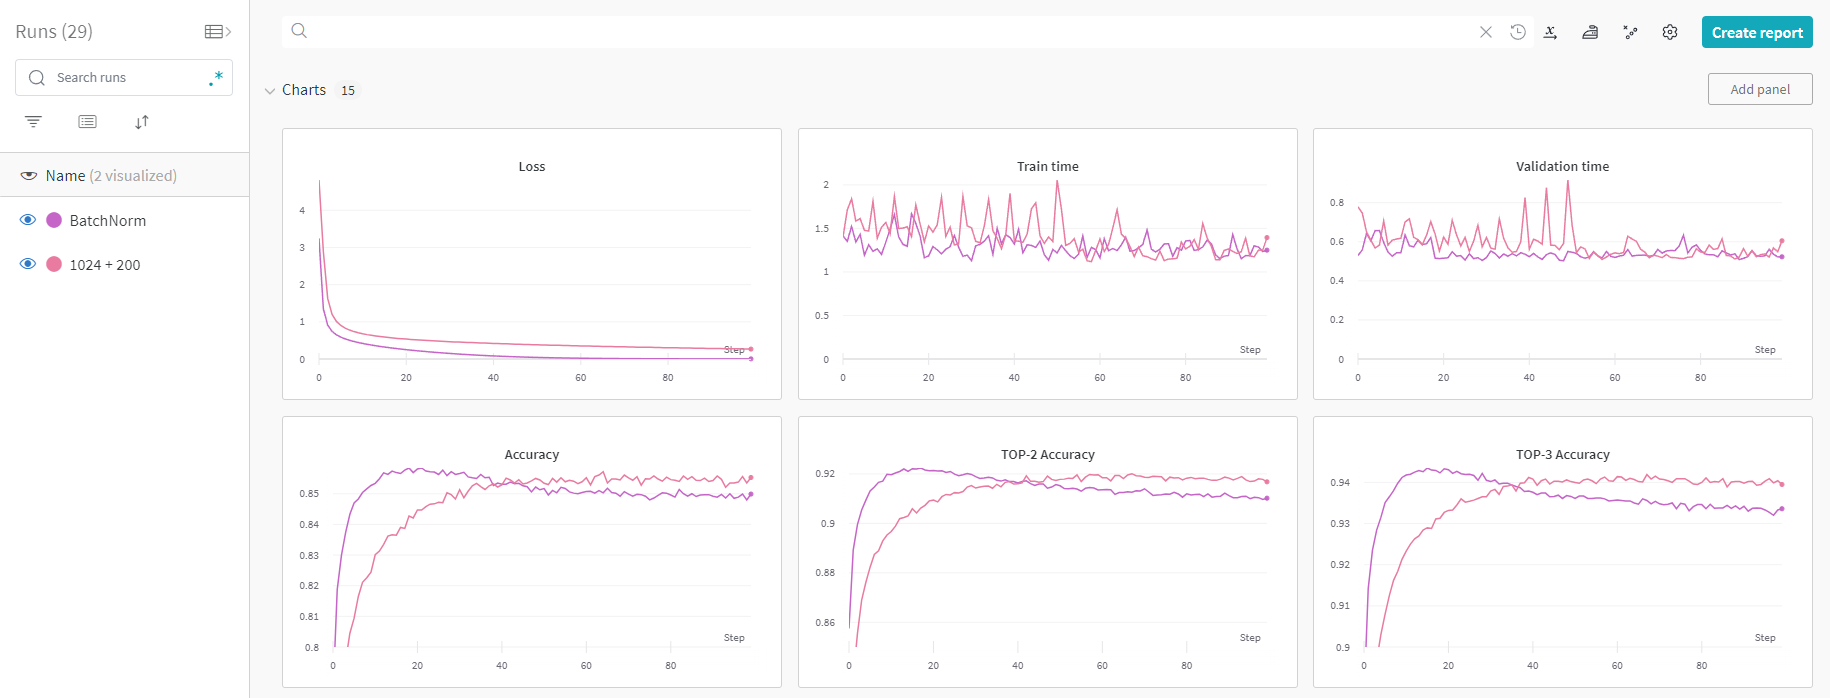

Действительно, добавление нормализации позволяет немного улучшить качество модели. Тем не менее явно наблюдается переобучение. Попробуем с ним бороться.

#### Dropout

In [29]:
fix_random()
model = torch.nn.Sequential(torch.nn.Dropout(0.25), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(), torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200))
Classifier('Dropout', model, learning_rate = 3e-5).fit(train_features, test_features, 100).summary()

Fit Dropout              : 100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
0,1024 + 200,0.8572,0.9194,0.9407,0.9534,0.9601,0.9651,0.9680,0.9712,0.9731,0.860992,0.8572,0.857409,0.614153,1.713959,0.341416,65
1,200,0.8533,0.9167,0.9394,0.9530,0.9609,0.9655,0.9698,0.9723,0.9752,0.857142,0.8533,0.853485,0.553387,1.170635,0.452905,100
2,1024 + 512 + 200,0.8509,0.9123,0.9356,0.9479,0.9565,0.9605,0.9646,0.9681,0.9699,0.854629,0.8509,0.851123,0.540771,1.381037,0.325489,70
3,BatchNorm,0.8584,0.9216,0.9423,0.9534,0.9601,0.9651,0.9688,0.9722,0.9746,0.862021,0.8584,0.858619,0.516093,1.411596,0.277325,19
4,Dropout,0.8601,0.9215,0.9442,0.9550,0.9619,0.9669,0.9701,0.9735,0.9763,0.863818,0.8601,0.860196,0.517865,1.429280,0.374206,51


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 200)                 0               1              
├─0                          Dropout               (-1, 1024)                0               1              
├─1                          Linear                (-1, 1024)                1,049,600       1              
├─2                          BatchNorm1d           (-1, 1024)                4,097           1              
├─3                          GELU                  (-1, 1024)                0               1              
├─4                          Dropout               (-1, 1024)                0               1              
├─5                          Linear                (-1, 200)                 205,000         1              
Trainable params: 1

![Alternative Text][1699453987304]

[1699453987304]: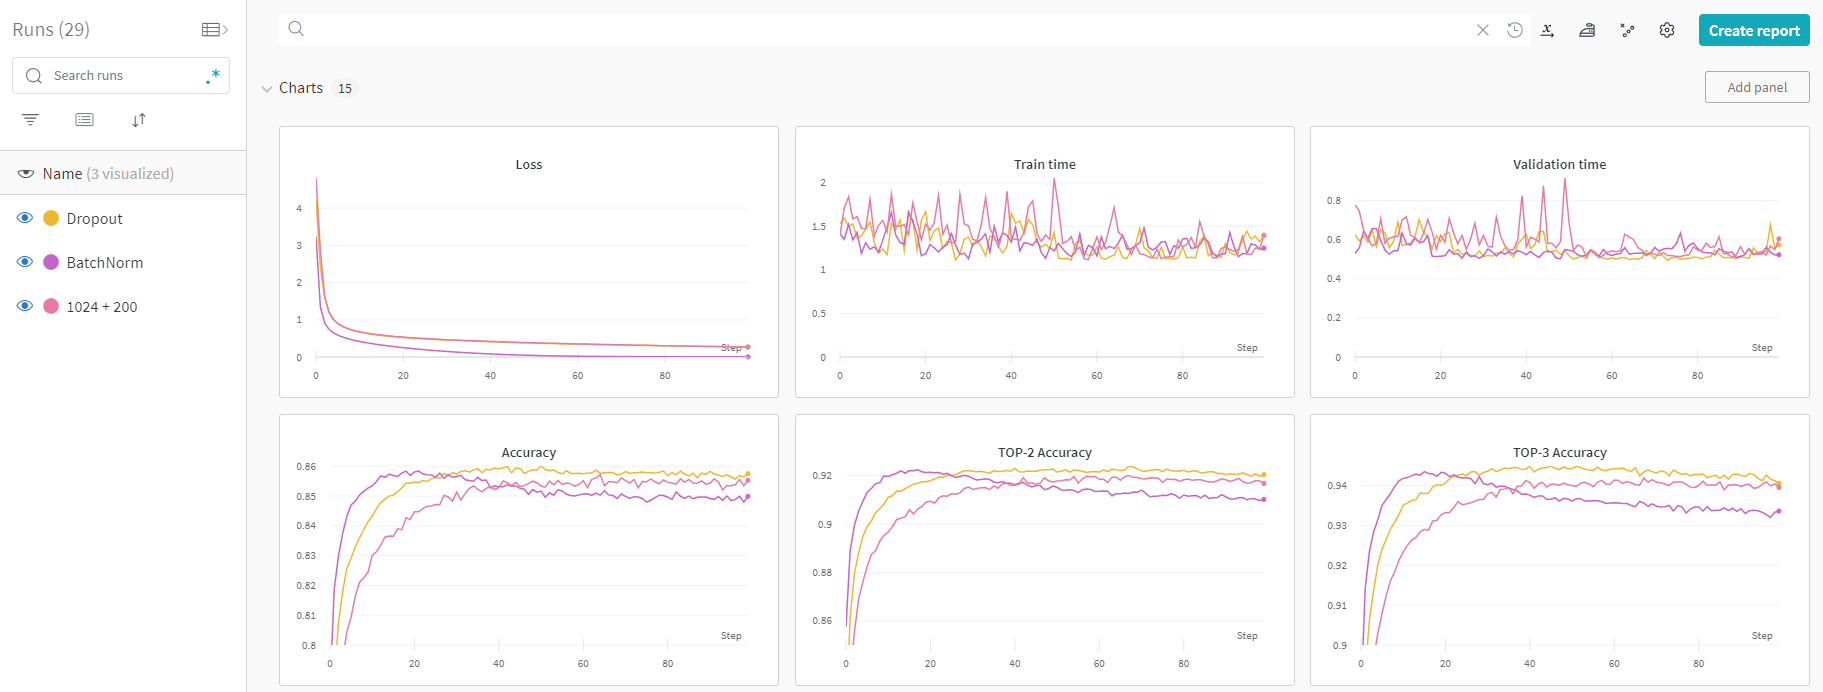

Лучшее качество достигается на 51 эпохе. Возьмём эту модель в качестве итоговой.

### Итоговая модель

In [30]:
fix_random()
model = torch.nn.Sequential(torch.nn.Dropout(0.25), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(), torch.nn.Dropout(0.5), torch.nn.Linear(1024, 200))
final_model = Classifier('Task 2 final', model, learning_rate = 3e-5).fit(train_features, test_features, 51)

Fit Task 2 final         : 100%|██████████| 51/51 [01:32<00:00,  1.81s/it]


In [31]:
accuracy = final_model.calc_metrics(test_features)['Accuracy']
print(f"Accuracy: {accuracy * 100}%")
print(f"Оценка за это задание составит {numpy.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

Accuracy: 86.00999999999999%
Оценка за это задание составит 10.00 баллов


## Отчёт об экспериментах 

### Задание 1
В ходе экспериментов было выявлено, что наибольшего качества достигает модель, поле восприятия которой равно размеру картинки: в этом случае модель учитывает всю предоставленную информацию ("видит" всю картинку, а не только ее части), но и не уменьшает картинку слишком сильно (что происходит при слишком большом поле восприятия). С учетом этого была построена достаточно простая модель, состоящая из 6 сверточных слоев с размерами ядер 3x3, между некоторыми из которых происходит применение макс-пулинга размера 2x2. Такая модель верно предсказывает класс для почти 47% объектов (что заметно превышает требуемое значение 44%).

### Задание 2

![Alternative Text][1699455460759]

[1699455460759]: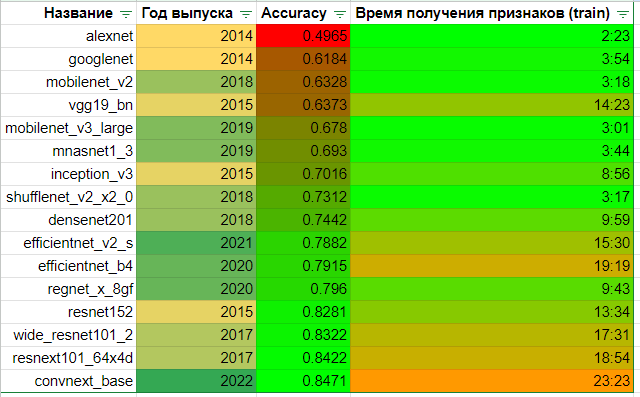

Ожидаемо, большие современные модели (`ConvNext`, `ResNext`, `ResNet`, `EfficientNet`) извлекают гораздо более хорошие, универсальные признаки, чем относительно простые архитектуры, созданные достаточно давно (`AlexNet`, `GoogleNet`). Тем не менее для больших моделей велико и время, необходимое для извлечения признаков (так, `AlexNet` затратил в 10 раз меньше времени, чем `ConvNext`). Также ожидаемо, что маленькие портативные модели, предназначенные для работы на мобильных устройствах (`MobileNet`, `MNASNet`) работают быстро, но и качество показывают относительно невысокое. Интересно, что `VGG` показывает достаточно низкое качество, несмотря на свой огромный размер и большое количество извлекаемых признаков.